Veri indiriliyor...


<ipython-input-1-fa1415a4007a>:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


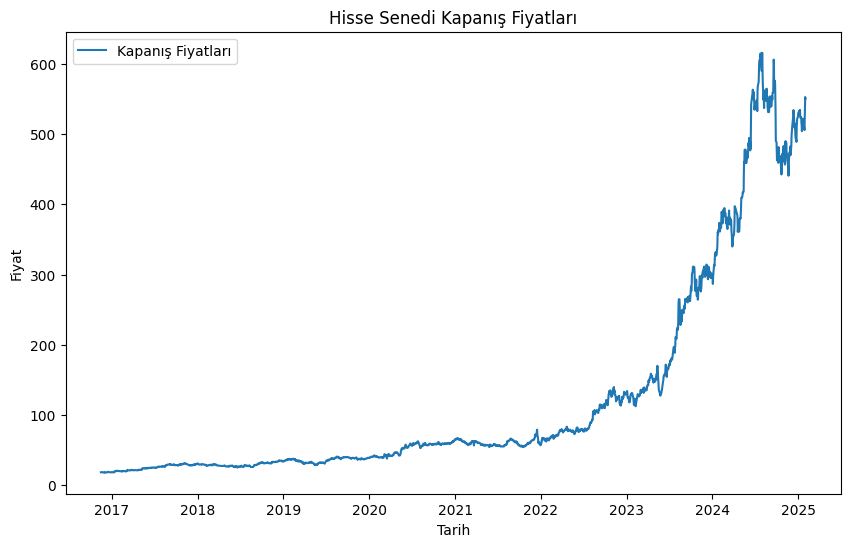


Linear Regression Modeli
R2 Skoru: 0.9959
RMSE: 9.0069
MAE: 4.4419

Gelecek gün tahminleri:
Gün 1: 508.44
Gün 2: 525.52
Gün 3: 549.63
Gün 4: 555.66
Gün 5: 553.15


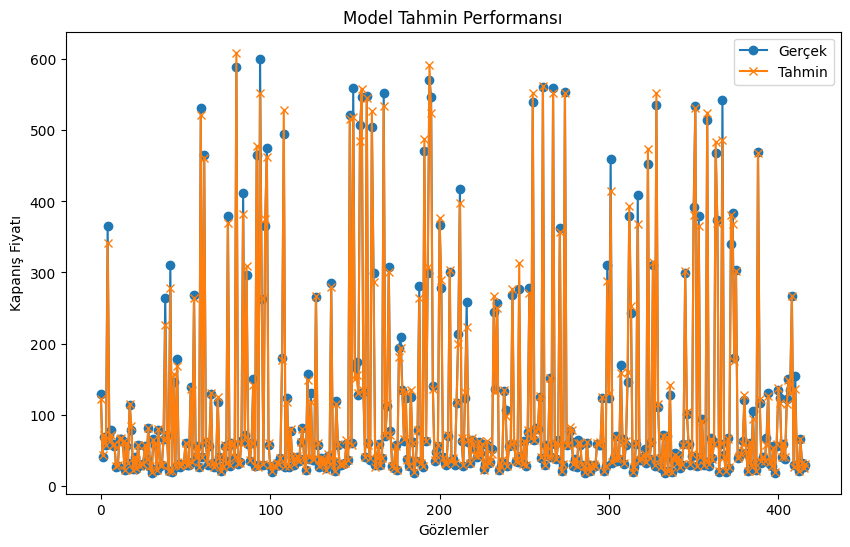


KNN Modeli
En iyi KNN parametreleri: {'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}
R2 Skoru: 0.9964
RMSE: 8.4157
MAE: 4.0056

Gelecek gün tahminleri:
Gün 1: 519.28
Gün 2: 514.88
Gün 3: 556.11
Gün 4: 551.70
Gün 5: 550.10


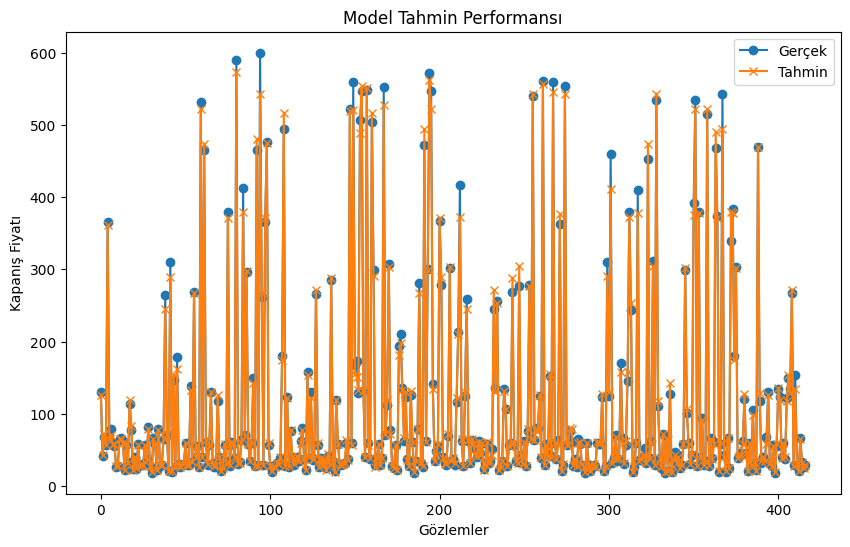


Random Forest Modeli
En iyi Random Forest parametreleri: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
R2 Skoru: 0.9966
RMSE: 8.2120
MAE: 3.9864

Gelecek gün tahminleri:
Gün 1: 518.53
Gün 2: 518.72
Gün 3: 546.99
Gün 4: 543.02
Gün 5: 546.73


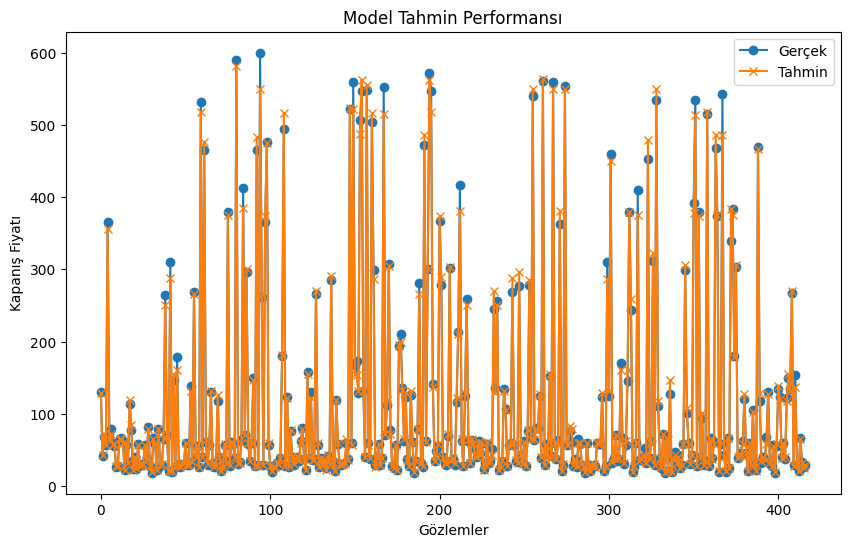

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Veri indirme fonksiyonu
def download_data(stock_symbol, start_date, end_date):
    """Yahoo Finance'tan hisse senedi verilerini indirir."""
    return yf.download(stock_symbol, start=start_date, end=end_date, progress=False)

# Veri görselleştirme fonksiyonu
def visualize_data(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Close'], label="Kapanış Fiyatları")
    plt.title("Hisse Senedi Kapanış Fiyatları")
    plt.xlabel("Tarih")
    plt.ylabel("Fiyat")
    plt.legend()
    plt.show()

# Hiperparametre optimizasyon fonksiyonu
def optimize_model(model, param_grid, X_train, y_train):
    """Hiperparametre optimizasyonu yapar."""
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Model eğitme ve değerlendirme fonksiyonu
def evaluate_model(model, X_train, X_test, y_train, y_test, X_forecast):
    """Modeli eğitir, test eder ve tahmin yapar."""
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Performans metrikleri
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    print(f"R2 Skoru: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Gelecek gün tahminleri
    forecast_preds = model.predict(X_forecast)
    print("\nGelecek gün tahminleri:")
    for i, pred in enumerate(forecast_preds, 1):
        print(f"Gün {i}: {pred:.2f}")

    # Test verisi tahminlerini görselleştirme
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, label="Gerçek", marker="o")
    plt.plot(range(len(predictions)), predictions, label="Tahmin", marker="x")
    plt.title("Model Tahmin Performansı")
    plt.xlabel("Gözlemler")
    plt.ylabel("Kapanış Fiyatı")
    plt.legend()
    plt.show()

    return model

# Ana parametreler
stock = "BIMAS.IS"
today = datetime.date.today()
duration = 3000
start_date = today - datetime.timedelta(days=duration)
end_date = today
forecast_days = 5

# Veri indirme
print("Veri indiriliyor...")
data = download_data(stock, start_date, end_date)
data.fillna(method='ffill', inplace=True)
visualize_data(data)

# Özellik ve hedef oluşturma
data['preds'] = data['Close'].shift(-forecast_days)
scaler = StandardScaler()
X = scaler.fit_transform(data[['Close']].iloc[:-forecast_days])
y = data['preds'].iloc[:-forecast_days].values
X_forecast = scaler.transform(data[['Close']].iloc[-forecast_days:])

# Veri setini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Modeli
print("\nLinear Regression Modeli")
lr_model = LinearRegression()
evaluate_model(lr_model, X_train, X_test, y_train, y_test, X_forecast)

# KNN Modeli
print("\nKNN Modeli")
knn_model = KNeighborsRegressor()
knn_param_grid = {'n_neighbors': range(1, 20), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
optimized_knn, knn_best_params = optimize_model(knn_model, knn_param_grid, X_train, y_train)
print(f"En iyi KNN parametreleri: {knn_best_params}")
evaluate_model(optimized_knn, X_train, X_test, y_train, y_test, X_forecast)

# Random Forest Modeli
print("\nRandom Forest Modeli")
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
optimized_rf, rf_best_params = optimize_model(rf_model, rf_param_grid, X_train, y_train)
print(f"En iyi Random Forest parametreleri: {rf_best_params}")
evaluate_model(optimized_rf, X_train, X_test, y_train, y_test, X_forecast)